<a href="https://colab.research.google.com/github/julwalzajjj/BMSTUtasks/blob/main/L5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install implicit

In [2]:
!pip install lightfm

In [3]:
!pip install tools

In [4]:
!pip install catboost

In [5]:
import pandas as pd
import numpy as np
# import faiss
import random
# import scann
# import ngtpy

from tqdm import notebook, tqdm

import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, coo_matrix
# from lightfm import LightFM
# from lightfm.evaluation import recall_at_k, precision_at_k, auc_score
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from tqdm import tqdm
from implicit.nearest_neighbours import BM25Recommender, CosineRecommender, TFIDFRecommender
from implicit.evaluation import mean_average_precision_at_k, ndcg_at_k, AUC_at_k

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

# from feature_engine.creation import CyclicalFeatures

from gensim.models import Word2Vec

from sklearn.datasets import dump_svmlight_file

import warnings
warnings.filterwarnings('ignore')
import implicit

from scipy.stats import norm

import tqdm

/usr/local/lib/python3.10/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [6]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    data = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/wb_school_task_1.csv.gzip", compression='gzip')
except:
    data = pd.read_csv(r"C:\Users\User\Documents\wildberries\wb_school_task_1.csv.gzip", compression='gzip')

Mounted at /content/drive


In [7]:
def precision_at_k(recommendations, purchases, k):
    recommended_list = np.array(recommendations)
    flags = np.isin(purchases, recommended_list)

    return flags.sum()/len(recommendations)

def recall_at_k(recommendations, purchases, k):
    recommended_list = np.array(recommendations)[:k]
    purchases = np.array(purchases)
    flags = np.isin(purchases, recommended_list)

    return flags.sum()/len(purchases)

def ndcg_metric(gt_items, predicted, at):
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
                  dtype=np.float64)

### Отчистка данных от выбросов

In [8]:
def outlinersGrubbs(data, column, percent):
    df = data.copy()
    df['g_score'] = np.abs(df[column] - df[column].mean()) / df[column].std()
    df['p_value'] = 2 * norm.sf(abs(df['g_score']))
    return df.sort_values(by='p_value', ascending=True).head(round(df.shape[0]*percent/100))

def multiInd(x):
    indexes = list(x.index)
    first_col = []
    second_col = []
    for row in indexes:
        first_col.append(row[1])
        second_col.append(row[0])
    return first_col, second_col

# CleaningOutliners
# input: data - датасет,
#        p1 - процент выбросов для больших заказов,
#        p2 - процент выбросов для количества заказов у пользователя,
#        p3 - процент выбросов для заказов с одинаковыми товарами,
#        p4 - процент выбросов для активных юзеров,
#        p5 - процент выбросов для популярных товаров,
# otput: df - отчищенный датасет

def CleaningOutliners(data, p1=0.002, p2=0.005, p3=0.001, p4=0.02, p5=0.01):

    df = data.copy()

    orders = df.groupby(['order_ts', 'user_id']).count()
    orders_out = outlinersGrubbs(orders, 'item_id', p1)
    users_bg_orders, dates_bg_orders = multiInd(orders_out)
    df = df[~(df['user_id'].isin(users_bg_orders) & df['order_ts'].isin(dates_bg_orders))]

    cnt_orders = df.drop(['item_id'], axis=1).drop_duplicates().groupby(['user_id']).count()
    cnt_orders_out = outlinersGrubbs(cnt_orders, 'order_ts', p2)
    df = df[~(df['user_id'].isin(cnt_orders_out.index))]

    duplicated_items = df[df.duplicated()].value_counts().sort_values(ascending=False)
    duplicated_items = pd.DataFrame(duplicated_items, columns=['items_cnt'])
    duplicated_items_out = outlinersGrubbs(duplicated_items, 'items_cnt', p3)
    items_dup, users_dup = multiInd(duplicated_items_out)
    df = df[~(df['user_id'].isin(users_dup) & df['item_id'].isin(items_dup))]

    data_wo_date = df.drop(['order_ts'], axis = 1)
    users_cnt_items = data_wo_date.groupby(['user_id']).count()
    users_cnt_items_out = outlinersGrubbs(users_cnt_items, 'item_id', p4)
    df = df[~(df['user_id'].isin(users_cnt_items_out.index))]

    data_wo_date = df.drop(['order_ts'], axis = 1)
    items_cnt_users = data_wo_date.groupby(['item_id']).count()
    items_cnt_users_out = outlinersGrubbs(items_cnt_users, 'user_id', p5)
    df = df[~(df['item_id'].isin(items_cnt_users_out.index) | df['item_id'].isin(
        items_cnt_users[items_cnt_users['user_id'] == 1].index))]

    return df

In [9]:
data_clean = CleaningOutliners(data)

In [10]:
data_clean['order_ts'] = pd.to_datetime(data_clean['order_ts'])

Оставим в тестовой выборке последние 2 недели:

In [11]:
max_date = data_clean['order_ts'].max()
train = data_clean[data_clean['order_ts'] < max_date - pd.Timedelta(days=7)]
test = data_clean[data_clean['order_ts'] >= max_date - pd.Timedelta(days=7)]

In [12]:
train.shape

(18918059, 3)

In [13]:
test.shape

(1669776, 3)

In [14]:
lfm_date_threshold = train['order_ts'].quantile(q=0.7, interpolation='nearest')
lfm_date_threshold

Timestamp('2023-03-02 06:54:50.119791')

In [15]:
lfm_train = train[(train['order_ts'] < lfm_date_threshold)]
lfm_val = train[(train['order_ts'] >= lfm_date_threshold)]

In [16]:
print(f"lfm_train: {lfm_train.shape}")
print(f"lfm_val: {lfm_val.shape}")

lfm_train: (13242641, 3)
lfm_val: (5675418, 3)


In [17]:
lfm_val = lfm_val[lfm_val['user_id'].isin(lfm_train['user_id'].unique())]

In [18]:
lfm_train.head(3)

,user_id,item_id,order_ts
0,550614,264,2023-01-01 00:28:09
3,47164,5135,2023-01-01 00:53:35
4,219072,2668,2023-01-01 01:02:29


In [19]:
lfm_train = lfm_train.groupby(['user_id', 'item_id']).count().astype(int).reset_index().rename(columns={"order_ts": "purchase"})
lfm_val = lfm_val.groupby(['user_id', 'item_id']).count().astype(int).reset_index().rename(columns={"order_ts": "purchase"})

In [20]:
from lightfm.data import Dataset
from lightfm import LightFM

In [21]:
dataset = Dataset()
dataset.fit(lfm_train['user_id'].unique(), lfm_train['item_id'].unique())

In [22]:
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['user_id', 'item_id', 'purchase']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

In [23]:
weights_matrix_csr

<944888x6301 sparse matrix of type '<class 'numpy.float32'>'
	with 9293067 stored elements in Compressed Sparse Row format>

In [24]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 944888
items_mapping amount: 6301


### LightFM Logistic

In [ ]:
model_lfm = LightFM(loss='logistic',
                    max_sampled=4,
                    no_components=7,
                    learning_rate=0.1,
                    item_alpha=0.001,
                    user_alpha=0.0001,
                    random_state=12345)

In [ ]:
num_epochs = 25

for _ in notebook.tqdm(range(num_epochs)):
    model_lfm.fit_partial(
        weights_matrix_csr
    )

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
model_lfm.item_biases = np.zeros_like(model_lfm.item_biases)

In [ ]:
num_epochs

25

In [ ]:
candidates = pd.DataFrame({
    'user_id': lfm_val['user_id'].unique()
})

candidates.head(3)

,user_id
0,3
1,4
2,8


In [ ]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features, num_threads=num_threads)

        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]

        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [ ]:
# import tools
# from tools import generate_lightfm_recs_mapper

# кол-во кандидатов
top_N = 50

# вспомогательные данные
all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    model_lfm,
    item_ids=all_cols,
    known_items=dict(),
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=8
)

In [ ]:
candidates['item_id'] = candidates['user_id'].map(mapper)
candidates = candidates.explode('item_id')
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1

candidates.head()

,user_id,item_id,rank
0,3,7619,1
0,3,2292,2
0,3,2246,3
0,3,5617,4
0,3,7426,5


In [ ]:
candidates.to_csv(r"/content/drive/MyDrive/Colab Notebooks/candidates_1.csv.gzip", compression='gzip')

In [ ]:
candidates = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/candidates_1.csv.gzip", compression='gzip')

In [ ]:
pred_interactions = candidates.drop(['rank'], axis=1).groupby('user_id')['item_id'].agg(lambda x: list(set(x)))
test_interactions = test.drop(['order_ts'], axis=1).groupby('user_id')['item_id'].agg(lambda x: list(set(x)))

In [ ]:
pred_interactions = pd.DataFrame(pred_interactions)
pred_interactions.columns=['pred_items']
test_interactions = pd.DataFrame(test_interactions)
test_interactions.columns=['test_items']

In [ ]:
val_interactions = lfm_val.drop(['purchase'], axis=1).groupby('user_id')['item_id'].agg(lambda x: list(set(x)))

val_interactions = pd.DataFrame(val_interactions)
val_interactions.columns=['val_items']

In [ ]:
joined = pred_interactions.join(test_interactions, how='inner')

In [ ]:
joined.to_csv(r"/content/drive/MyDrive/Colab Notebooks/joined.csv.gzip", compression='gzip')

In [ ]:
joined = joined.join(val_interactions, how='inner')

In [ ]:
joined.head()

,pred_items,test_items
user_id,,
3,"[640, 7426, 1923, 1285, 1803, 2831, 4498, 531,...","[163, 1635, 50, 180, 343, 184, 217]"
8,"[640, 7426, 1923, 1285, 1803, 2831, 4498, 531,...",[712]
15,"[640, 7426, 1923, 1285, 1803, 2831, 4498, 531,...",[3180]
20,"[640, 7426, 1923, 1285, 1803, 2831, 4498, 531,...","[249, 212, 390]"
25,"[640, 7426, 1923, 1285, 1803, 2831, 4498, 531,...","[7704, 1294, 1939, 435, 438, 440, 1116]"


In [ ]:
joined['recall@20'] = joined.apply(lambda row: recall_at_k(row['pred_items'], row['test_items'], 20), axis=1)

In [ ]:
joined['recall@20_val'] = joined.apply(lambda row: recall_at_k(row['pred_items'], row['val_items'], 20), axis=1)

In [ ]:
joined['recall@10'] = joined.apply(lambda row: recall_at_k(row['pred_items'], row['test_items'], 10), axis=1)

In [ ]:
joined['precision@20'] = joined.apply(lambda row: precision_at_k(row['pred_items'], row['test_items'], 20), axis=1)

In [ ]:
round(joined['recall@20'].mean(), 2)

0.0

In [ ]:
joined['ndcg@20'] = joined.apply(lambda row: ndcg_metric(row['test_items'], row['pred_items'], 20), axis=1)

In [ ]:
round(joined['ndcg@20'].mean()*100, 2)

0.79

In [ ]:
joined['recall@50'] = joined.apply(lambda row: recall_at_k(row['pred_items'], row['test_items'], 50), axis=1)

In [ ]:
round(joined['recall@50'].mean(), 2)

0.0

In [ ]:
len(joined.index)

468253

In [ ]:
uniq_recs = len(joined['pred_items'].astype(str).unique())
users_1 = len(joined.index)

print(f'Уникальность {uniq_recs/users_1*100:.2f}')

Уникальность 0.00


In [ ]:
combined = []
for list in joined['pred_items']:
    combined += list

# считаем количество уникальных элементов
unique_elements = len(set(combined))

print(unique_elements)

50


Было: 0.13
ndcg 43,67
уник 0

50 айтемов

### LightFM Warp


In [25]:
model_lfm = LightFM(loss='warp',
                    max_sampled=4,
                    no_components=5,
                    learning_rate=0.1,
                    item_alpha=0.001,
                    user_alpha=0.0001,
                    random_state=12345)

In [26]:
num_epochs = 25

for _ in notebook.tqdm(range(num_epochs)):
    model_lfm.fit_partial(
        weights_matrix_csr
    )

  0%|          | 0/25 [00:00<?, ?it/s]

In [27]:
# model_lfm.item_biases = np.zeros_like(model_lfm.item_biases)

In [28]:
num_epochs

25

In [29]:
candidates = pd.DataFrame({
    'user_id': lfm_val['user_id'].unique()
})

candidates.head(3)

,user_id
0,3
1,4
2,8


In [30]:
def generate_lightfm_recs_mapper(model, item_ids, known_items, user_features, item_features, N, user_mapping, item_inv_mapping, num_threads=4):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features, item_features=item_features, num_threads=num_threads)

        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]

        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [31]:
top_N = 50

all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    model_lfm,
    item_ids=all_cols,
    known_items=dict(),
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=8
)

In [32]:
candidates['item_id'] = candidates['user_id'].map(mapper)
candidates = candidates.explode('item_id')
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1

In [33]:
candidates.head()

,user_id,item_id,rank
0,3,390,1
0,3,357,2
0,3,133,3
0,3,69,4
0,3,11,5


In [ ]:
# candidates = candidates.drop(['index', 'Unnamed: 0'], axis=1)

In [34]:
candidates.reset_index(inplace=True, drop=True)

Сохранение в файл:

In [ ]:
candidates.to_csv(r"/content/drive/MyDrive/Colab Notebooks/candidates_1.csv.gzip", compression='gzip')
# candidates = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/candidates_1.csv.gzip", compression='gzip')

In [ ]:
candidates = candidates.drop(['Unnamed: 0', 'rank'], axis=1)

In [ ]:
candidates['item_id'] = candidates['item_id'].astype(int)

In [ ]:
items_category = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/wb_school_task_1_items_description.csv")

In [ ]:
items_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6562 entries, 0 to 6561
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   item_id    6562 non-null   int64 
 1   item_name  6562 non-null   object
dtypes: int64(1), object(1)
memory usage: 102.7+ KB


In [ ]:
items_category

,item_id,item_name
0,847,Дозаторы для ванной
1,6036,Шпульки для швейных машин
2,6447,Наборы хирургические
3,8279,Лобзики
4,2416,Полотенца спортивные
...,...,...
6557,854,Емкости для выпечки
6558,350,Косметические карандаши
6559,517,Планшеты
6560,8239,Комбинезоны утепленные


In [ ]:
candidates

,user_id,item_id,rank
0,3,6218,1
1,3,5142,2
2,3,5546,3
3,3,2139,4
4,3,683,5
...,...,...,...
33572195,1057264,2550,46
33572196,1057264,2035,47
33572197,1057264,1325,48
33572198,1057264,696,49


In [ ]:
result = pd.merge(candidates, items_category, on='item_id')

In [ ]:
result.head()

,user_id,item_id,rank,item_name
0,3,6218,1,Игрушечные мишени
1,4,6218,30,Игрушечные мишени
2,8,6218,15,Игрушечные мишени
3,11,6218,2,Игрушечные мишени
4,16,6218,3,Игрушечные мишени


In [ ]:
result.to_csv(r"/content/drive/MyDrive/Colab Notebooks/result.gzip", compression='gzip')

In [ ]:
categories_items = result.groupby('user_id').agg({
    'item_id': lambda x: list(set(x)),
    'item_name': lambda x: list(set(x)),
    'rank': lambda x: list(set(x))
})

In [ ]:
categories_test = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/categories_test.csv")

In [ ]:
categories_test.colmns = ['user_id', 'items_test', 'item_name_test']

In [ ]:
joined = pd.merge(categories_items, categories_test, on='user_id')

Привести к нужным типам

In [35]:
pred_interactions = candidates.groupby('user_id')['item_id'].agg(lambda x: list(set(x)))
test_interactions = test.drop(['order_ts'], axis=1).groupby('user_id')['item_id'].agg(lambda x: list(set(x)))

In [36]:
pred_interactions = pd.DataFrame(pred_interactions)
pred_interactions.columns=['pred_items']
test_interactions = pd.DataFrame(test_interactions)
test_interactions.columns=['test_items']

In [37]:
# val_interactions = lfm_val.drop(['purchase'], axis=1).groupby('user_id')['item_id'].agg(lambda x: list(set(x)))

# val_interactions = pd.DataFrame(val_interactions)
# val_interactions.columns=['val_items']

In [38]:
joined = pred_interactions.join(test_interactions, how='inner')

In [39]:
uniq_recs = len(joined['pred_items'].astype(str).unique())
users_1 = len(joined.index)

print(f'Уникальность {uniq_recs/users_1*100:.2f}')

Уникальность 14.08


In [ ]:
joined.head()

In [ ]:
categories_train = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/categories_train.csv")

In [ ]:
categories_train[categories_train['user_id'].isin([3,4,8,11,15])]['item_name']

2     ['Брюки', 'Беруши', 'Лубриканты', 'Портупеи', ...
3     ['Масла', 'Косметика для ванн', 'Полотенца бан...
7     ['Мягкие игрушки', 'Перчатки', 'Бисер', 'Време...
10    ['Наклейки на авто', 'Ламбрекены', 'Коврики ав...
13    ['Скотч для наращивания ресниц', 'Водоросли мо...
Name: item_name, dtype: object

In [ ]:
import ast

joined['item_id_y'] = joined['item_id_y'].apply(lambda x: ast.literal_eval(x))

In [40]:
joined['recall@20'] = joined.apply(lambda row: recall_at_k(row['pred_items'], row['test_items'], 20), axis=1)

In [41]:
round(joined['recall@20'].mean(), 2)

0.11

In [43]:
joined['recall@50'] = joined.apply(lambda row: recall_at_k(row['pred_items'], row['test_items'], 50), axis=1)

In [44]:
round(joined['recall@50'].mean(), 2)

0.26

In [42]:
combined = []
for list_ in joined['pred_items']:
    combined += list_

# считаем количество уникальных элементов
unique_elements = len(set(combined))

print(unique_elements)

780


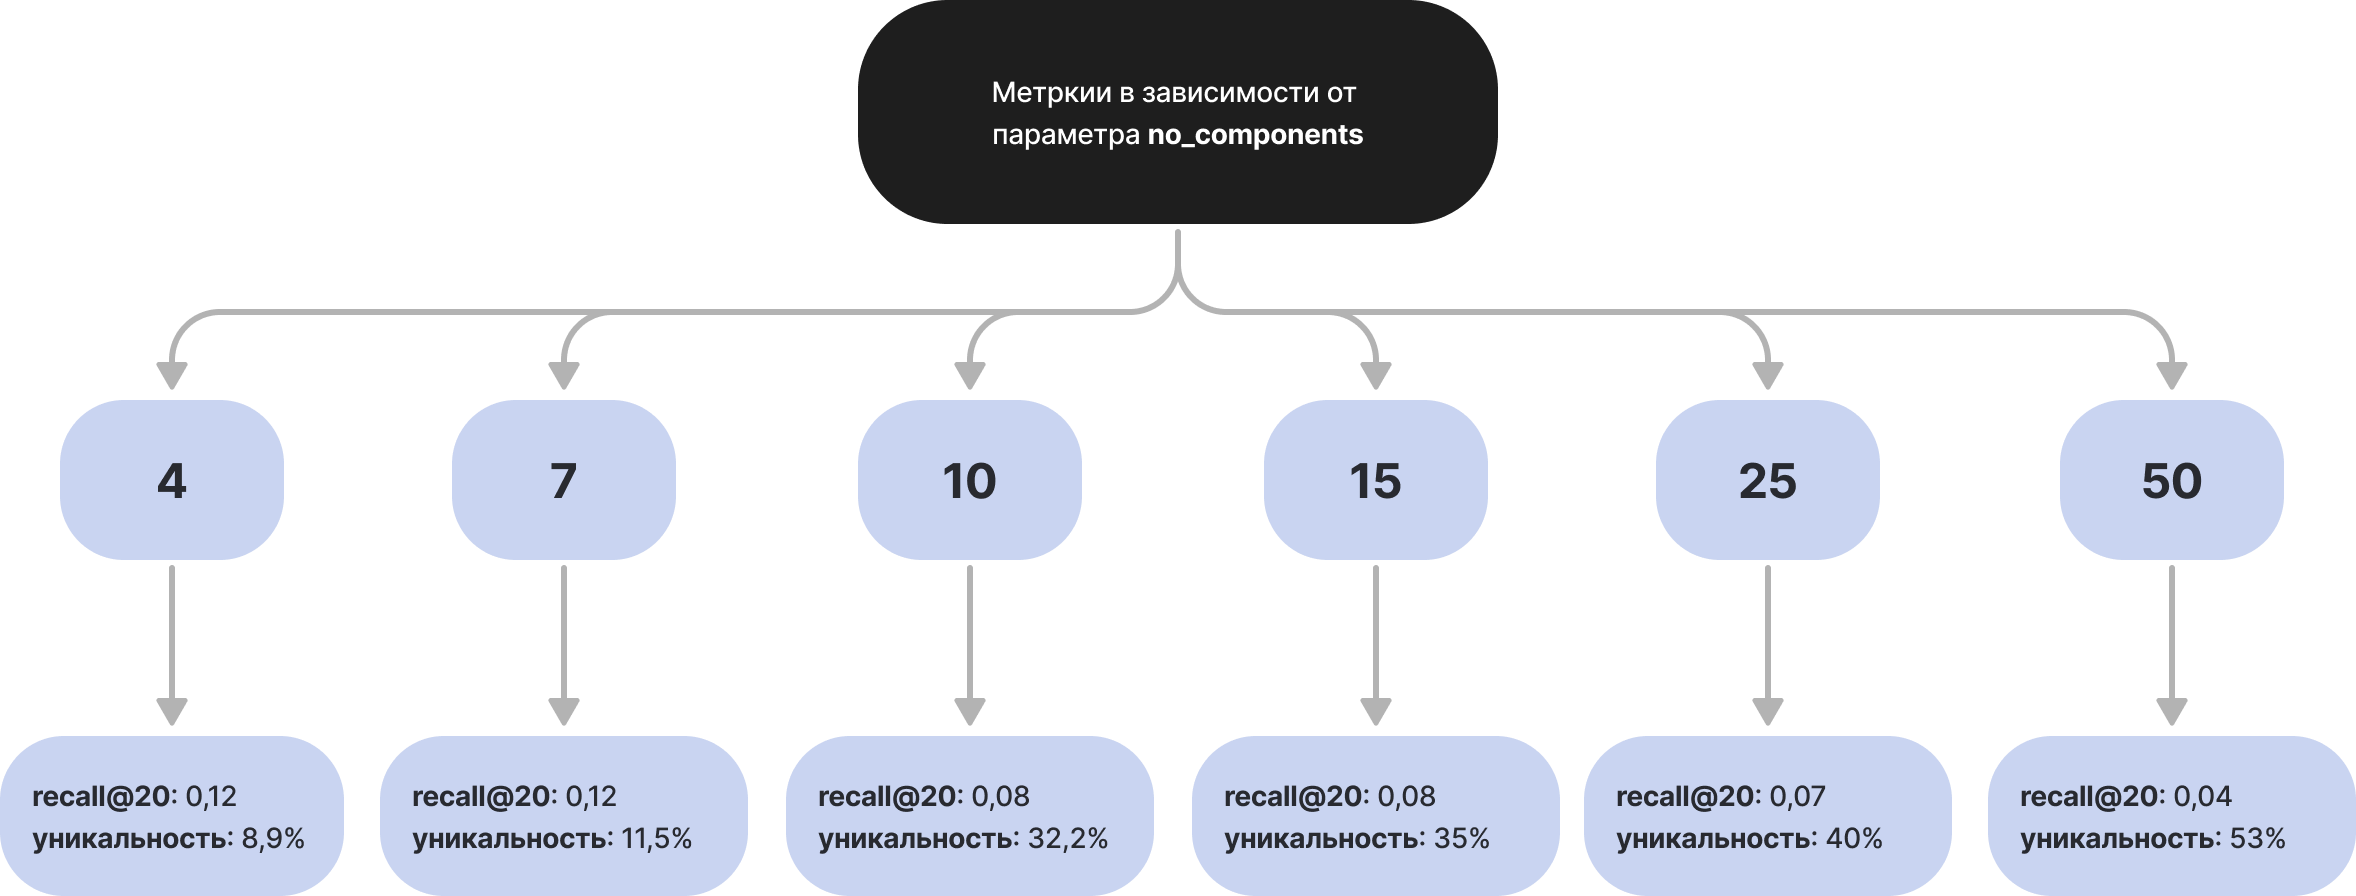

Чем больше полнота, тем меньше уникальность

In [ ]:
joined.to_csv(r"/content/drive/MyDrive/Colab Notebooks/lightfm_result.csv")

### Бустинг

In [ ]:
def EmbeddingsW2V(data, vector_users=2, vector_items=2, mc_users=1, mc_items=2):
  df = data.copy()

  features = df
  df = df[['user_id', 'item_id']]
  for_items = df.groupby('user_id')['item_id'].apply(list)
  for_users = df.groupby('item_id')['user_id'].apply(list)
  for_users_list = for_users.values.tolist()
  for_items_list = for_items.values.tolist()

  model_users = Word2Vec(sentences=for_users_list, vector_size=vector_users, min_count=mc_users)
  model_items = Word2Vec(sentences=for_items_list, vector_size=vector_items, min_count=mc_items)

  item_vectors = {item: model_items.wv[item] for item in model_items.wv.index_to_key}
  user_vectors = {user: model_users.wv[user] for user in model_users.wv.index_to_key}

  item_embeddings = pd.DataFrame(item_vectors).T
  user_embeddings = pd.DataFrame(user_vectors).T

  user_embeddings.columns = [f'u_ebd_{i}' for i in range(user_embeddings.shape[1])]
  item_embeddings.columns = [f'i_ebd_{i}' for i in range(item_embeddings.shape[1])]

  df = features.join(item_embeddings, on='item_id', how='left')
  df = df.join(user_embeddings, on='user_id', how='left')
  df.dropna(inplace=True)

  return df

In [ ]:
lfm_val_emb = EmbeddingsW2V(lfm_val)

In [ ]:
result = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/result.gzip", compression='gzip')

In [ ]:
result.info()

In [ ]:
lfm_val_emb.to_csv(r"/content/drive/MyDrive/Colab Notebooks/lfm_val_emb.csv.gzip", compression='gzip')

In [ ]:
lfm_val_emb = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/lfm_val_emb.csv.gzip", compression='gzip')

In [ ]:
lfm_val_emb = pd.merge(lfm_val_emb, items_category, on='item_id')

NameError: ignored

In [ ]:
result = result.drop(['Unnamed: 0'], axis=1)

In [ ]:
lfm_val_emb = lfm_val_emb.drop(['Unnamed: 0', 'purchase'], axis=1)

In [ ]:
candidates = result

In [ ]:
candidates_test = candidates[candidates['user_id'].isin(test['user_id'].unique())]

In [ ]:
candidates_test = candidates_test.drop(['rank'], axis=1)

In [ ]:
candidates_test_emb = EmbeddingsW2V(candidates_test)

In [ ]:
candidates_test_emb.to_csv(r"/content/drive/MyDrive/Colab Notebooks/candidates_test_emb.csv.gzip", compression='gzip')

In [ ]:
candidates_test_emb = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/candidates_test_emb.csv.gzip", compression='gzip')

In [ ]:
candidates_test_emb.head()

,Unnamed: 0,user_id,item_id,rank,i_ebd_0,i_ebd_1,u_ebd_0,u_ebd_1
0,0,3,390,1,11.843787,-18.704586,-0.785285,0.548839
1,0,3,357,2,10.892907,-17.208872,-0.785285,0.548839
2,0,3,11,3,9.962773,-15.739751,-0.785285,0.548839
3,0,3,133,4,9.208667,-14.572268,-0.785285,0.548839
4,0,3,69,5,8.409226,-13.336022,-0.785285,0.548839


In [ ]:
candidates_test_emb = candidates_test_emb.drop(['Unnamed: 0', 'rank'], axis=1)

In [ ]:
candidates_test_emb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18168578 entries, 0 to 18168577
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   user_id     int64  
 2   item_id     int64  
 3   item_name   object 
 4   i_ebd_0     float64
 5   i_ebd_1     float64
 6   u_ebd_0     float64
 7   u_ebd_1     float64
dtypes: float64(4), int64(3), object(1)
memory usage: 1.1+ GB


In [ ]:
test_interactions.shape

In [ ]:
lfm_val_emb.head()

,user_id,item_id,purchase,i_ebd_0,i_ebd_1,u_ebd_0,u_ebd_1,item_name
0,3,38,1,-3.084565,11.171661,-0.315501,0.500832,Юбки
1,26,38,1,-3.084565,11.171661,-0.217416,0.448336,Юбки
2,68,38,1,-3.084565,11.171661,0.407163,0.312010,Юбки
3,174,38,1,-3.084565,11.171661,0.060715,0.503782,Юбки
4,212,38,1,-3.084565,11.171661,0.391577,0.145613,Юбки


In [ ]:
pos = candidates.merge(lfm_val_emb.sample(frac=0.03).reset_index(drop=True),
                        on=['user_id', 'item_id'],
                        how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(29028, 11)


,user_id,item_id,rank,item_name_x,purchase,i_ebd_0,i_ebd_1,u_ebd_0,u_ebd_1,item_name_y,target
0,720561,3222,32,Удобрения для аквариумных растений,1,1.733437,-0.881681,0.128592,0.477462,Удобрения для аквариумных растений,1
1,228073,5923,3,Запчасти для игровых консолей,2,1.179034,-0.226879,-0.309348,-0.165779,Запчасти для игровых консолей,1
2,232201,1906,25,Фотобумага,2,2.365415,-1.627509,0.160548,-0.163572,Фотобумага,1
3,554280,1906,42,Фотобумага,1,2.365415,-1.627509,-0.000836,0.255449,Фотобумага,1
4,324628,1075,28,Флаги,1,1.209918,0.338230,0.061545,-0.209604,Флаги,1


In [ ]:
neg = candidates.merge(lfm_val_emb.sample(frac=0.03).reset_index(drop=True),
                        on=['user_id', 'item_id'],
                        how='inner')

original_user_id = neg['user_id'].copy()

# перемешиваю 10 раз
for i in range(10):
  neg = neg.sample(frac=1).reset_index(drop=True)

neg['target'] = 0

neg['user_id'] = original_user_id
print(neg.shape)
neg.head()

(28912, 11)


,user_id,item_id,rank,item_name_x,purchase,i_ebd_0,i_ebd_1,u_ebd_0,u_ebd_1,item_name_y,target
0,824195,180,12,Джинсы,4,-2.046568,8.219639,-0.268414,-0.343818,Джинсы,0
1,716564,357,2,Кремы,2,-1.085922,5.582368,0.202822,-0.068086,Кремы,0
2,452228,358,8,Шампуни,1,-1.136565,5.571000,0.125763,0.467073,Шампуни,0
3,121537,403,49,Косметические наборы для ухода,1,-0.344597,3.871610,0.351176,0.119002,Косметические наборы для ухода,0
4,502672,360,23,Маски косметические,2,-0.997153,5.540823,0.489206,0.011115,Маски косметические,0


In [ ]:
users_neg_list = list(neg['user_id'].unique())
users_pos_list = list(pos['user_id'].unique())
users_list = users_neg_list + users_pos_list

In [ ]:
len(users_list)

55299

In [ ]:
boost_train_users, boost_eval_users = train_test_split(users_list,
                                                  random_state=12345,
                                                  test_size=0.2)

In [ ]:
from sklearn.utils import shuffle

In [ ]:
select_col = ['user_id', 'item_id', 'i_ebd_0', 'i_ebd_1',	'u_ebd_0', 'u_ebd_1', 'target']

boost_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(boost_train_users)],
        neg[neg['user_id'].isin(boost_train_users)]
])[select_col]
)
boost_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(boost_eval_users)],
        neg[neg['user_id'].isin(boost_eval_users)]
])[select_col]
)

In [ ]:
boost_train.to_csv(r"/content/drive/MyDrive/Colab Notebooks/boost_train.csv.gzip", compression='gzip')
boost_eval.to_csv(r"/content/drive/MyDrive/Colab Notebooks/boost_eval.csv.gzip", compression='gzip')

In [ ]:
boost_train = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/boost_train.csv.gzip", compression='gzip')
boost_eval = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/boost_eval.csv.gzip", compression='gzip')

In [ ]:
boost_train.head()

,Unnamed: 0,user_id,item_id,i_ebd_0,i_ebd_1,u_ebd_0,u_ebd_1,target
0,23541,415856,347,-1.315949,6.640485,-0.062888,-0.057413,0
1,15590,143883,390,-0.322670,3.687626,-0.161314,0.218592,0
2,21193,145398,358,-1.136565,5.571000,0.473498,0.269192,0
3,25770,451067,212,-1.728919,7.275840,-0.141487,0.304016,0
4,16621,775142,357,-1.085922,5.582368,0.129260,-0.446478,0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

boost_train[['user_id', 'item_id']] = scaler.fit_transform(boost_train[['user_id', 'item_id']])
boost_eval[['user_id', 'item_id']] = scaler.transform(boost_eval[['user_id', 'item_id']])

NameError: ignored

In [ ]:
boost_train.head()

,Unnamed: 0,user_id,item_id,i_ebd_0,i_ebd_1,u_ebd_0,u_ebd_1,target
0,23541,-0.371696,-0.080453,-1.315949,6.640485,-0.062888,-0.057413,0
1,15590,-1.263366,-0.025406,-0.322670,3.687626,-0.161314,0.218592,0
2,21193,-1.258399,-0.066371,-1.136565,5.571000,0.473498,0.269192,0
3,25770,-0.256255,-0.253277,-1.728919,7.275840,-0.141487,0.304016,0
4,16621,0.806233,-0.067652,-1.085922,5.582368,0.129260,-0.446478,0


In [ ]:
boost_train = boost_train.drop(['Unnamed: 0'], axis=1)

In [ ]:
boost_eval = boost_eval.drop(['Unnamed: 0'], axis=1)

In [ ]:
boost_train['target'].value_counts(normalize=True)

1    0.50058
0    0.49942
Name: target, dtype: float64

In [ ]:
boost_train.reset_index(drop=True, inplace=True)
boost_eval.reset_index(drop=True, inplace=True)

In [ ]:
target_col = ['target']
cat_col = ['user_id', 'item_id', 'i_ebd_0',	'i_ebd_1',	'u_ebd_0',	'u_ebd_1']

X_train, y_train = boost_train.drop(target_col, axis=1), boost_train[target_col]
X_val, y_val = boost_eval.drop(target_col, axis=1), boost_eval[target_col]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((47411, 6), (47411, 1), (12632, 6), (12632, 1))

In [ ]:
X_train = X_train.fillna(X_train.mode().iloc[0])

X_val = X_val.fillna(X_train.mode().iloc[0])
X_train.head()

,user_id,item_id,i_ebd_0,i_ebd_1,u_ebd_0,u_ebd_1
0,-0.371696,-0.080453,-1.315949,6.640485,-0.062888,-0.057413
1,-1.263366,-0.025406,-0.322670,3.687626,-0.161314,0.218592
2,-1.258399,-0.066371,-1.136565,5.571000,0.473498,0.269192
3,-0.256255,-0.253277,-1.728919,7.275840,-0.141487,0.304016
4,0.806233,-0.067652,-1.085922,5.582368,0.129260,-0.446478


In [ ]:
X_val.head()

,user_id,item_id,i_ebd_0,i_ebd_1,u_ebd_0,u_ebd_1
0,0.937000,-0.272479,-1.599215,6.712908,0.197403,-0.057009
1,0.145816,-0.071492,-1.048928,5.893210,0.219863,-0.360629
2,1.431359,0.033482,-0.352188,3.829090,0.261424,-0.174876
3,-0.587478,-0.246876,-1.764114,7.382505,-0.235980,0.100309
4,1.046021,-0.264798,-1.931937,7.760610,-0.176201,0.425440


In [ ]:
import catboost as cb

In [ ]:
group_id_train = np.repeat(0, y_train.shape[0])
group_id_val = np.repeat(0, y_val.shape[0])

train_data = cb.Pool(data=X_train, label=y_train, group_id=group_id_train)
val_data = cb.Pool(data=X_val, label=y_val, group_id=group_id_val)

catboost_params = {'iterations': 15,
                  'custom_metric': ['NDCG'],
                  'verbose': True,
                  'random_seed': 12345,
                  'loss_function' : 'YetiRank',
                  'depth' : 10,
                  'learning_rate' : 0.001
                  }

model = cb.CatBoost(catboost_params)
model.fit(train_data,
        eval_set=val_data,
        early_stopping_rounds=100,
        plot=True,
        verbose=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.0015023	best: 0.0015023 (0)	total: 37.8s	remaining: 8m 48s
1:	test: 0.6141250	best: 0.6141250 (1)	total: 54.8s	remaining: 5m 56s
2:	test: 0.8500000	best: 0.8500000 (2)	total: 1m 10s	remaining: 4m 43s
3:	test: 1.0000000	best: 1.0000000 (3)	total: 1m 27s	remaining: 4m
4:	test: 0.8500000	best: 1.0000000 (3)	total: 1m 43s	remaining: 3m 27s
5:	test: 1.0000000	best: 1.0000000 (3)	total: 2m 1s	remaining: 3m 1s
6:	test: 1.0000000	best: 1.0000000 (3)	total: 2m 16s	remaining: 2m 36s
7:	test: 0.8500000	best: 1.0000000 (3)	total: 2m 33s	remaining: 2m 14s
8:	test: 1.0000000	best: 1.0000000 (3)	total: 2m 49s	remaining: 1m 52s
9:	test: 1.0000000	best: 1.0000000 (3)	total: 3m 6s	remaining: 1m 33s
10:	test: 1.0000000	best: 1.0000000 (3)	total: 3m 23s	remaining: 1m 13s
11:	test: 0.8500000	best: 1.0000000 (3)	total: 3m 39s	remaining: 54.9s
12:	test: 1.0000000	best: 1.0000000 (3)	total: 3m 55s	remaining: 36.2s
13:	test: 0.6141250	best: 1.0000000 (3)	total: 4m 13s	remaining: 18.1s
14:	test: 0.52

In [ ]:
model.save_model(r"/content/drive/MyDrive/Colab Notebooks/model_cb.cbm")

### Метрики моделей

In [ ]:
candidates_test_emb = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/candidates_test_emb.csv.gzip", compression='gzip')

In [ ]:
candidates_test_emb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18168700 entries, 0 to 18168699
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   user_id     int64  
 2   item_id     int64  
 3   rank        int64  
 4   i_ebd_0     float64
 5   i_ebd_1     float64
 6   u_ebd_0     float64
 7   u_ebd_1     float64
dtypes: float64(4), int64(4)
memory usage: 1.1 GB


In [ ]:
boost_train = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/boost_train.csv.gzip", compression='gzip')

catboost_params = {'iterations': 15,
                  'custom_metric': ['NDCG'],
                  'verbose': True,
                  'random_seed': 12345,
                  'loss_function' : 'YetiRank',
                  'depth' : 10,
                  'learning_rate' : 0.001
                  }

model = cb.CatBoost(catboost_params)

model.load_model(r"/content/drive/MyDrive/Colab Notebooks/model_cb.cbm")

In [ ]:
candidates_test_emb_scaled = candidates_test_emb.copy()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
boost_train[['user_id', 'item_id']] = scaler.fit_transform(boost_train[['user_id', 'item_id']])

candidates_test_emb_scaled[['user_id', 'item_id']] = scaler.transform(candidates_test_emb[['user_id', 'item_id']])

In [ ]:
predictions = model.predict(candidates_test_emb_scaled)
candidates_test_emb['rank_cb'] = predictions

In [ ]:
items_category = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/wb_school_task_1_items_description.csv")

In [ ]:
candidates_test_emb = pd.merge(candidates_test_emb, items_category, on='item_id')

In [ ]:
candidates_test_emb.head()

,user_id,item_id,i_ebd_0,i_ebd_1,u_ebd_0,u_ebd_1,rank_cb,item_name
0,3,390,11.843787,-18.704586,-0.785285,0.548839,0.006183,Чехлы для телефонов
1,8,390,11.843787,-18.704586,-1.293664,1.254832,0.006183,Чехлы для телефонов
2,15,390,11.843787,-18.704586,-0.416988,1.558553,0.002281,Чехлы для телефонов
3,20,390,11.843787,-18.704586,-1.058058,1.166776,0.006183,Чехлы для телефонов
4,25,390,11.843787,-18.704586,-0.980047,1.990257,0.006183,Чехлы для телефонов


In [ ]:
pred_interactions = candidates_test_emb.groupby('user_id')['item_id'].agg(lambda x: list(x))
rankes = candidates_test_emb.groupby('user_id')['rank_cb'].agg(lambda x: list(x))

In [ ]:
item_groups = candidates_test_emb.groupby('user_id')['item_name'].agg(lambda x: list(x))

In [ ]:
test_data = cb.Pool(data=candidates_test_emb_scaled)

In [ ]:
predictions = model.predict(test_data)

In [ ]:
candidates_test_emb['rank_cb'] = predictions

In [ ]:
pred_interactions = candidates_test_emb.groupby('user_id')['item_id'].agg(lambda x: list(x))
rankes = candidates_test_emb.groupby('user_id')['rank_cb'].agg(lambda x: list(x))
item_groups = candidates.groupby('user_id')['item_name'].agg(lambda x: list(x))

In [ ]:
result_rank = pd.DataFrame(pred_interactions).join(pd.DataFrame(rankes), how='inner')
result_rank = pd.DataFrame(result_rank).join(pd.DataFrame(item_groups), how='inner')

In [ ]:
test_ = test.groupby('user_id').agg({
    'item_id': lambda x: list(set(x))
})

In [ ]:
test_.columns = ['item_id_test']

In [ ]:
joined = result_rank.join(test_, how='inner')

In [ ]:
joined.to_csv(r"/content/drive/MyDrive/Colab Notebooks/ranked_items.csv.gzip", compression='gzip')

In [ ]:
joined['sorted_items'] = joined.apply(lambda row: [value for _, value in sorted(zip(row['rank_cb'], row['item_id']))], axis=1)

In [ ]:
joined['recall@20'] = joined.apply(lambda row: recall_at_k(row['sorted_items'], row['item_id_test'], 20), axis=1)

In [ ]:
round(joined['recall@20'].mean(), 2)

0.12

In [ ]:
joined.head()

,item_id,rank_cb,item_name,item_id_test,sorted_items,recall@20,ndcg@20
user_id,,,,,,,
3,"[390, 357, 11, 133, 69, 212, 381, 358, 1571, 3...","[0.006183249749881193, 0.002572115208327814, 0...","[Чехлы для телефонов, Кремы, Брюки, Трусы, Пла...","[163, 1635, 50, 180, 343, 184, 217]","[106, 151, 153, 165, 403, 406, 105, 353, 354, ...",0.285714,0.888673
8,"[390, 357, 11, 133, 69, 212, 381, 358, 1571, 3...","[0.006183249749881193, 0.002572115208327814, 0...","[Чехлы для телефонов, Кремы, Брюки, Трусы, Пла...",[712],"[106, 151, 153, 165, 403, 406, 105, 353, 354, ...",0.000000,0.000000
15,"[390, 357, 11, 133, 69, 212, 381, 358, 1571, 3...","[0.002280954912153121, -0.0013301796294002573,...","[Чехлы для телефонов, Кремы, Брюки, Трусы, Пла...",[3180],"[11, 38, 41, 50, 69, 76, 82, 94, 133, 148, 162...",0.000000,0.000000
20,"[390, 357, 11, 133, 69, 212, 381, 358, 1571, 3...","[0.006183249749881193, 0.002572115208327814, 0...","[Чехлы для телефонов, Кремы, Брюки, Трусы, Пла...","[249, 212, 390]","[106, 151, 153, 165, 403, 406, 105, 353, 354, ...",0.000000,0.693426
25,"[390, 357, 11, 133, 69, 212, 381, 358, 1571, 3...","[0.006183249749881193, 0.002572115208327814, 0...","[Чехлы для телефонов, Кремы, Брюки, Трусы, Пла...","[7704, 1294, 1939, 435, 438, 440, 1116]","[106, 151, 153, 165, 403, 406, 105, 353, 354, ...",0.000000,0.000000


In [ ]:
categories_test = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/categories_test.csv")

3 юзер:

In [ ]:
items_category[items_category['item_id'].isin(joined.loc[3, 'sorted_items'])]['item_name'].values

array(['Кружки', 'Сумки', 'Комплекты белья', 'Бюстгальтеры', 'Топы',
       'Патчи', 'Куртки', 'Платья', 'Наушники', 'Блузки',
       'Постельное белье', 'Бальзамы', 'Трусы', 'Масла', 'Кремы', 'Книги',
       'Шапки', 'Кроссовки', 'Рубашки', 'Лонгсливы', 'Чай', 'Серьги',
       'Ботинки', 'Костюмы', 'Джинсы', 'Костюмы спортивные', 'Гели',
       'Свитеры', 'Пижамы', 'Носки', 'Тапочки', 'Шорты', 'Леггинсы',
       'Дезодоранты', 'Шампуни', 'Спреи', 'Корректоры', 'Защитные стекла',
       'Чехлы для телефонов', 'Маски косметические', 'Духи', 'Юбки',
       'Косметические наборы для ухода', 'Сыворотки', 'Основы под макияж',
       'Водолазки', 'Туши', 'Колготки', 'Брюки',
       'Косметические карандаши'], dtype=object)

In [ ]:
categories_train[categories_train['user_id'].isin([3])]['item_name'].values

array(["['Брюки', 'Беруши', 'Лубриканты', 'Портупеи', 'Пиджаки', 'Лотки для бумаг', 'Босоножки', 'Органайзеры для хранения', 'Кухонные весы', 'Комплекты белья', 'Блузки-боди', 'Блузки', 'Топы', 'Гели', 'Сабо', 'Велосипедки', 'Юбки']"],
      dtype=object)

In [ ]:
categories_test[categories_test['user_id'].isin([3])]['item_name'].values

array(["['Лонгсливы', 'Куртки', 'Джинсы', 'Сумки', 'Босоножки', 'Ботильоны', 'Рубашки', 'Свитеры', 'Ботфорты', 'Бомберы', 'Топы']"],
      dtype=object)

15 юзер:

In [ ]:
items_category[items_category['item_id'].isin(joined.loc[15, 'sorted_items'])]['item_name'].values

array(['Кружки', 'Сумки', 'Комплекты белья', 'Бюстгальтеры', 'Топы',
       'Патчи', 'Куртки', 'Платья', 'Наушники', 'Блузки',
       'Постельное белье', 'Бальзамы', 'Трусы', 'Масла', 'Кремы', 'Книги',
       'Шапки', 'Кроссовки', 'Рубашки', 'Лонгсливы', 'Чай', 'Серьги',
       'Ботинки', 'Костюмы', 'Джинсы', 'Костюмы спортивные', 'Гели',
       'Свитеры', 'Пижамы', 'Носки', 'Тапочки', 'Шорты', 'Леггинсы',
       'Дезодоранты', 'Шампуни', 'Спреи', 'Корректоры', 'Защитные стекла',
       'Чехлы для телефонов', 'Маски косметические', 'Духи', 'Юбки',
       'Косметические наборы для ухода', 'Сыворотки', 'Основы под макияж',
       'Водолазки', 'Туши', 'Колготки', 'Брюки',
       'Косметические карандаши'], dtype=object)

In [ ]:
categories_train[categories_train['user_id'].isin([15])]['item_name'].values

array(["['Скотч для наращивания ресниц', 'Водоросли морские', 'Носки', 'Пинцеты для наращивания ресниц', 'Наборы для наращивания ресниц', 'Патчи для наращивания ресниц', 'Зеркала косметические', 'Тени', 'Инструменты для чистки лица', 'Чехлы для наушников', 'Наушники', 'Кольцевые лампы', 'Клей для наращивания ресниц']"],
      dtype=object)

In [ ]:
categories_test[categories_test['user_id'].isin([15])]['item_name'].values

array(["['Лакомства для животных', 'Миски для животных', 'Ошейники']"],
      dtype=object)

In [ ]:
joined['ndcg@20'] = joined.apply(lambda row: ndcg_metric(row['item_id_test'], row['sorted_items'], 20), axis=1)

In [ ]:
round(joined['ndcg@20'].mean()*100, 2)

43.67

### Другие модели

Оставим юзеров в обоих выборках

In [ ]:
def common_users(train, test):
  users_test = list(test['user_id'].unique())
  users_train = list(train['user_id'].unique())
  users_tt = list(set(users_train) & set(users_test))
  return users_tt

In [ ]:
def common_items(train, test):
  items_test = list(test['item_id'].unique())
  items_train = list(train['item_id'].unique())
  items_tt = list(set(items_train) & set(items_test))
  return items_tt

In [ ]:
users_test = list(test['user_id'].unique())
users_train = list(train['user_id'].unique())
users_tt = list(set(users_train) & set(users_test))
len(set(users_train) & set(users_test))

348651

In [ ]:
def refresh(train, test):
  users = common_users(train, test)
  items = common_items(train, test)

  train_new_1 = train[train['item_id'].isin(items)]
  train_new = train_new_1[train_new_1['user_id'].isin(users)]

  test_new_1 = test[test['item_id'].isin(items)]
  test_new = test_new_1[test_new_1['user_id'].isin(users)]

  return train_new, test_new, len(users), len(items)

In [ ]:
train_refresh, test_refresh, u, i = refresh(train, test)

In [ ]:
train_refresh.shape

(11395917, 3)

In [ ]:
test_refresh.shape

(1142486, 3)

In [ ]:
train_refresh, test_refresh, u, i = refresh(train_refresh, test_refresh)

In [ ]:
print(f'Пользователей :  {u}')
print(f'Айтемов :  {i}')

Пользователей :  348640
Айтемов :  5458


In [ ]:
train_refresh.user_id.nunique()

348640

In [ ]:
test_refresh.user_id.nunique()

348638

Функции для создания csr-матриц user-item:

In [ ]:
def get_coo_matrix(
        df: pd.DataFrame,
        user_col: str,
        item_col: str,
        users_mapping: dict,
        items_mapping: dict,
        weight_col: str = None
        ):
    if weight_col is None:
        weights = np.ones(len(df), dtype=np.float32)
    else:
        weights = df[weight_col].astype(np.float32)
    interaction_matrix = coo_matrix((
        weights,
        (
            df[user_col].map(users_mapping.get),
            df[item_col].map(items_mapping.get)
        )
    ))
    return interaction_matrix

In [ ]:
def get_user_item_matrix(data):
  df = data.copy()

  users_inv_mapping = dict(enumerate(df['user_id'].unique()))
  users_mapping = {v: k for k, v in users_inv_mapping.items()}

  items_inv_mapping = dict(enumerate(df['item_id'].unique()))
  items_mapping = {v: k for k, v in items_inv_mapping.items()}

  df = df.groupby(['user_id', 'item_id']).count().astype(int).reset_index().rename(columns={"order_ts": "purchase"})

  matrix = get_coo_matrix(
    df,
    user_col='user_id',
    item_col='item_id',
    users_mapping=users_mapping,
    items_mapping=items_mapping
    ).tocsr()

  return matrix

Выделим валидационную выборку из тренировочной:

In [ ]:
val = train[train['order_ts'].dt.week == 12]
train = train[train['order_ts'].dt.week != 12]

In [ ]:
train.shape

(17694613, 3)

In [ ]:
val.shape

(1720179, 3)

In [ ]:
train, val, u, i = refresh(train, val)

In [ ]:
train.user_id.nunique()

429353

In [ ]:
val.user_id.nunique()

429353

In [ ]:
print(f'Пользователей :  {u}')
print(f'Айтемов :  {i}')

Пользователей :  429353
Айтемов :  5637


In [ ]:
train_user_item = get_user_item_matrix(train)
val_user_item = get_user_item_matrix(val)

In [ ]:
train_user_item

<429353x5637 sparse matrix of type '<class 'numpy.float32'>'
	with 7976495 stored elements in Compressed Sparse Row format>

In [ ]:
val_user_item

<429353x5637 sparse matrix of type '<class 'numpy.float32'>'
	with 1312899 stored elements in Compressed Sparse Row format>

Обновим тестовую выборку с учетом изменения тренировочной под валидацонную:

In [ ]:
train, test, u, i = refresh(train, test)

In [ ]:
train, val, u, i = refresh(train, val)

In [ ]:
val.user_id.nunique()

229716

In [ ]:
train.user_id.nunique()

229716

In [ ]:
test.user_id.nunique()

229716

In [ ]:
train_user_item = get_user_item_matrix(train)
val_user_item = get_user_item_matrix(val)
test_user_item = get_user_item_matrix(test)

LightFM

Для **233992** юзеров:

In [ ]:
from lightfm import LightFM

In [ ]:

model_lfm = LightFM(loss='warp',
                    no_components=60,
                    learning_rate=0.1,
                    item_alpha=0.005,
                    user_alpha=0.001,
                    max_sampled=5)

model_lfm.fit(train_user_item,
              epochs=20)

In [ ]:
recall_at_20 = recall_at_k(model=model_lfm, test_interactions=val_user_item, k=20).mean()

In [ ]:
print(recall_at_20)

0.0604011637022875


In [ ]:
recalls_validate = validate(train, num=5)

  0%|          | 0/5 [00:00<?, ?it/s]

0.03719583521364611

In [ ]:
n = 1
max_week = 12

In [ ]:
weeks = [max_week - x for x in range(n)]

In [ ]:
weeks

[12]

Валидация модели

In [ ]:
def validate(train, num=3):
  max_week = 12
  recalls_at_20 = []

  for n in notebook.tqdm(range(1, num + 1)):
    weeks = [max_week - x for x in range(n)]
    val = train[train['order_ts'].dt.week.isin(weeks)]
    train_new = train[~train['order_ts'].dt.week.isin(weeks)]

    train_, val_, u, i = refresh(train_new, val)
    train_refresh, val_refresh, u, i = refresh(train_, val_)

    train_user_item = get_user_item_matrix(train_refresh)
    val_user_item = get_user_item_matrix(val_refresh)

    model_lfm = LightFM(loss='warp',
                      no_components=25,
                      learning_rate=0.03,
                      item_alpha=0.0005,
                      user_alpha=0.0001)

    model_lfm.fit(train_user_item,
                epochs=20)

    recalls_at_20.append(recall_at_k(model=model_lfm, test_interactions=val_user_item, k=20).mean())

  return recalls_at_20

In [ ]:
def hyperparameters(train_user_item, val_user_item):
  no_comp = [20, 30, 40]
  loss = ['logistic', 'warp', 'bpr']
  learn_rate = [0.05, 0.1]
  item_alpha = [0.001, 0.01]
  user_alpha = [0.0001]
  epochs = [40]
  best_recall = 0
  for ech in epochs:
    for n_c in no_comp:
      for ls in loss:
        for lr in learn_rate:
          for ia in item_alpha:
            for ua in user_alpha:
              model_lfm = LightFM(loss=ls,
                                  no_components=n_c,
                                  learning_rate=lr,
                                  item_alpha=ia,
                                  user_alpha=ua)

              model_lfm.fit(train_user_item,
                            epochs=ech)

              recall_20 = recall_at_k(model=model_lfm, test_interactions=val_user_item, k=20).mean()
              parameters = [n_c, ls, lr, ia, ua, ech]
              print(f'Параметры : {parameters} recall@20 : {recall_20}')

              if recall_20 > best_recall:
                best_recall = recall_20
                best_parameters = parameters
  return best_recall, best_parameters

In [ ]:
recall_at_20, parameters_lfm = hyperparameters(train_user_item, val_user_item)

Параметры : [20, 'logistic', 0.05, 0.001, 0.0001, 40] recall@20 : 0.06934942548631837
Параметры : [20, 'logistic', 0.05, 0.01, 0.0001, 40] recall@20 : 0.019325171196304742
Параметры : [20, 'logistic', 0.1, 0.001, 0.0001, 40] recall@20 : 0.06893232234061158
Параметры : [20, 'logistic', 0.1, 0.01, 0.0001, 40] recall@20 : 0.07429658250279333
Параметры : [20, 'warp', 0.05, 0.001, 0.0001, 40] recall@20 : 0.07064659029292909
Параметры : [20, 'warp', 0.05, 0.01, 0.0001, 40] recall@20 : 0.0032409109512898495
Параметры : [20, 'warp', 0.1, 0.001, 0.0001, 40] recall@20 : 0.00720315432152052
Параметры : [20, 'warp', 0.1, 0.01, 0.0001, 40] recall@20 : 0.07302901172160502
Параметры : [20, 'bpr', 0.05, 0.001, 0.0001, 40] recall@20 : 0.06845725586888667
Параметры : [20, 'bpr', 0.05, 0.01, 0.0001, 40] recall@20 : 0.0011611231702981664
Параметры : [20, 'bpr', 0.1, 0.001, 0.0001, 40] recall@20 : 0.0032048991223136286
Параметры : [20, 'bpr', 0.1, 0.01, 0.0001, 40] recall@20 : 0.0013952113020037043
Парамет

Попробуем проверить на тестовой выборке:

In [ ]:
model_lfm = LightFM(loss='logistic',
                  no_components=60,
                  learning_rate=0.1,
                  item_alpha=0.01,
                  user_alpha=0.001,
                  max_sampled=5)

model_lfm.fit(train_user_item,
            epochs=40)

In [ ]:
recall_at_20 = recall_at_k(model=model_lfm, test_interactions=val_user_item, k=20).mean()
recall_at_50 = recall_at_k(model=model_lfm, test_interactions=val_user_item, k=50).mean()

print(recall_at_20)
print(recall_at_50)

0.03785057958392625
0.07003494742319788


In [ ]:
recall_at_20 = recall_at_k(model=model_lfm, test_interactions=test_user_item, k=20).mean()
recall_at_50 = recall_at_k(model=model_lfm, test_interactions=test_user_item, k=50).mean()

print(recall_at_20)
print(recall_at_50)

0.025069562954633803
0.08079578652053514
